# Contrastive Classification

This jupyter notebook contains a training script for the https://github.com/beresandras/contrastive-classification-keras repository, and is intended to be used in a Google Colab environment.

In [2]:
#uncomment on first run
!git clone https://github.com/beresandras/contrastive-classification-keras.git

Cloning into 'contrastive-classification-keras'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 138 (delta 70), reused 103 (delta 35), pack-reused 0 (from 0)
Receiving objects: 100% (138/138), 716.21 KiB | 2.29 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [5]:
!pip install tensorflow==2.2.0


ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.2.0


In [6]:
import sys
import pickle

from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.layers.experimental import preprocessing

sys.path.insert(0,'/content/contrastive-classification-keras')
from dataset import prepare_dataset
from augmentations import RandomResizedCrop, RandomColorJitter
from algorithms import SimCLR, NNCLR, DCCLR, BarlowTwins, HSICTwins, TWIST, MoCo, DINO

In [44]:
# hyperparameters
num_epochs = 10
steps_per_epoch = 200
width = 128

# hyperparameters corresponding to each algorithm
hyperparams = {
    SimCLR: {"temperature": 0.1},
    NNCLR: {"temperature": 0.1, "queue_size": 10000},
    DCCLR: {"temperature": 0.1},
    BarlowTwins: {"redundancy_reduction_weight": 10.0},
    HSICTwins: {"redundancy_reduction_weight": 3.0},
    TWIST: {},
    MoCo: {"momentum_coeff": 0.99, "temperature": 0.1, "queue_size": 10000},
    DINO: {"momentum_coeff": 0.9, "temperature": 0.1, "sharpening": 0.5},
}

In [9]:
# load STL10 dataset
batch_size, train_dataset, labeled_train_dataset, test_dataset = prepare_dataset(
    steps_per_epoch
)

batch size is 500 (unlabeled) + 25 (labeled)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.PQOB5V_1.0.0/stl10-train.tfrecord*...:   0%|          | 0…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.PQOB5V_1.0.0/stl10-test.tfrecord*...:   0%|          | 0/…

Generating unlabelled examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.PQOB5V_1.0.0/stl10-unlabelled.tfrecord*...:   0%|        …

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


In [16]:
for batch in train_dataset:
  batch_test = batch
  break

In [34]:
batch_test[0][0][0]

<tf.Tensor: shape=(96, 96, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[115, 114, 119],
        [124, 129, 132],
        [116, 120, 125],
        ...,
        [143, 144, 144],
        [142, 143, 144],
        [145, 145, 145]],

       ...,

       [[ 76,  67,  64],
        [ 74,  65,  63],
        [ 69,  63,  63],
        ...,
        [ 75,  72,  72],
        [ 80,  77,  77],
        [ 82,  79,  79]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0]

In [40]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torch
import tensorflow as tf

def visualize_image(image_tensor):
    """
    Visualizes an image tensor.

    Args:
        image_tensor (tf.Tensor): Image tensor of shape (3, H, W).
    """
    # Convert TensorFlow tensor to NumPy array
    image_tensor = tf.transpose(image_tensor, perm=[2, 0, 1])
    image_array = image_tensor.numpy()
    # Convert NumPy array to PyTorch tensor
    torch_tensor = torch.tensor(image_array)
    # Use TF.to_pil_image for visualization
    image_pil = TF.to_pil_image(torch_tensor)
    plt.imshow(image_pil)
    plt.axis('off')
    plt.show()

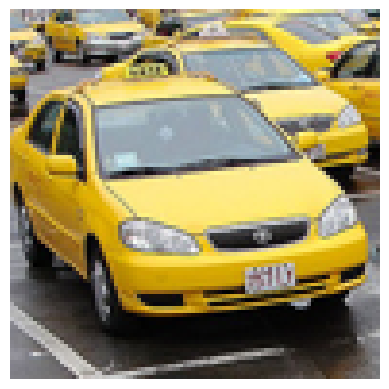

In [42]:
visualize_image(batch_test[0][0][1])

In [46]:
# select an algorithm
Algorithm = DCCLR

# architecture
model = Algorithm(
    contrastive_augmenter=keras.Sequential(
        [
            layers.Input(shape=(96, 96, 3)),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            RandomResizedCrop(scale=(0.2, 1.0), ratio=(3 / 4, 4 / 3)),
            RandomColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        ],
        name="contrastive_augmenter",
    ),
    classification_augmenter=keras.Sequential(
        [
            layers.Input(shape=(96, 96, 3)),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            RandomResizedCrop(scale=(0.5, 1.0), ratio=(3 / 4, 4 / 3)),
            RandomColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        ],
        name="classification_augmenter",
    ),
    encoder=keras.Sequential(
        [
            layers.Input(shape=(96, 96, 3)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    ),
    projection_head=keras.Sequential(
        [
            layers.Input(shape=(width,)),
            layers.Dense(width, activation="relu"),
            layers.Dense(width),
        ],
        name="projection_head",
    ),
    linear_probe=keras.Sequential(
        [
            layers.Input(shape=(width,)),
            layers.Dense(10),
        ],
        name="linear_probe",
    ),
    **hyperparams[Algorithm],
)

In [49]:
# optimizers
model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

# run training
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

# save history
with open("{}.pkl".format(Algorithm.__name__), "wb") as write_file:
    pickle.dump(history.history, write_file)

AttributeError: 'SparseCategoricalAccuracy' object has no attribute 'reset_states'